In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from lightgbm import LGBMRegressor, plot_importance
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from tqdm import tqdm
from skmisc.loess import loess
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression

In [2]:
def sample_train_start_point(data, n_test, n_prod, n_retrainings):
    idx_train_start = np.random.randint(0, len(data) - (2 * n_test * n_retrainings + n_prod))
    
    return idx_train_start

In [3]:
def train_test_prod_split(data, target, min_n_train, idx_train_start, n_test, n_prod, increment):
    idx_train_end = idx_train_start + min_n_train + n_test * increment
    
    idx_test_start = idx_train_end
    idx_test_end = idx_test_start + n_test
    
    idx_prod_start = idx_test_end
    idx_prod_end = idx_prod_start + n_prod
    
    # split data
    X_train = data.iloc[idx_train_start:idx_train_end]
    X_test = data.iloc[idx_test_start:idx_test_end]
    X_prod = data.iloc[idx_prod_start:idx_prod_end]

    # split targets
    y_train = target.iloc[idx_train_start:idx_train_end]
    y_test = target.iloc[idx_test_start:idx_test_end]
    y_prod = target.iloc[idx_prod_start:idx_prod_end]
    
    return X_train, X_test, X_prod, y_train, y_test, y_prod

In [4]:
def compute_model_errors(data, target, model, min_n_train, idx_train_start, n_test, n_prod, retraining_id):
    # create random split
    X_train, X_test, X_prod, y_train, y_test, y_prod = train_test_prod_split(data, target, min_n_train,
                                                                             idx_train_start, n_test,
                                                                             n_prod, retraining_id)
    # cross-validation for timeseries
    tscv = TimeSeriesSplit(n_splits=4)
    train_errors = []
    val_errors = []
    y_dict = {}
    for i, (train_index, val_index) in enumerate(tscv.split(X_train)):
        X_train_fold = X_train.iloc[train_index]
        y_train_fold = y_train.iloc[train_index]
        
        X_val_fold = X_train.iloc[val_index]
        y_val_fold = y_train.iloc[val_index]
        
        # train the model
        model.fit(X_train, y_train)
    
        # make predictions
        y_train_pred_fold = model.predict(X_train_fold)
        y_val_pred_fold = model.predict(X_val_fold)
        
        # calculate fold errors
        # TODO: allow other metrics
        train_error_fold = mean_absolute_percentage_error(y_train_fold, y_train_pred_fold)
        val_error_fold = mean_absolute_percentage_error(y_val_fold,  y_val_pred_fold)
        
        train_errors.append(train_error_fold)
        val_errors.append(val_error_fold)
        
    # rule for a valid model
    # TODO: pass this as a parameter
    if np.mean(val_errors) < 0.2 and np.mean(train_errors) < 0.2:
        is_model_valid = True
    else:
        is_model_valid = False
    
    # train on all the data
    X = pd.concat([X_train, X_test])
    y = pd.concat([y_train, y_test])
    model.fit(X, y)
    y_train_pred = model.predict(X)
    y_test_pred = model.predict(X_test)
    y_prod_pred = model.predict(X_prod)

    # calculate errors
    train_errors = np.abs(y - y_train_pred)
    test_errors = np.abs(y_test - y_test_pred)
    prod_errors = np.abs(y_prod - y_prod_pred)
    
    y_train_dict = {}
    y_test_dict = {}
    y_prod_dict = {}
    
    y_train_dict['y'] = y
    y_train_dict['y_pred'] = y_train_pred
    y_train_dict['partition'] = 'train'
    
    y_test_dict['y'] = y_test
    y_test_dict['y_pred'] = y_test_pred
    y_test_dict['partition'] = 'test'
    
    y_prod_dict['y'] = y_prod
    y_prod_dict['y_pred'] = y_prod_pred
    y_prod_dict['partition'] = 'prod'
        
    return y_train_dict, y_test_dict, y_prod_dict, is_model_valid

In [5]:
def continuos_retraining_runner(data, target, model, min_n_train, n_test, n_prod, n_simulations, n_retrainings):
    
    # n_retrainings = np.floor((len(data) - n_train - n_val - n_test) / n_val).astype(int)

    # empty error lists
    simulation_results = []
    for simulation_id in tqdm(range(n_simulations)):
        idx_train_start = sample_train_start_point(data, n_test, n_prod, n_retrainings)
        model.set_params(random_state=np.random.randint(0, n_simulations))
        retraining_results = []
        # for every simulation compute the models errors, append the errors to the error lists
        for retraining_id in range(n_retrainings):
            train_errors, val_errors, test_errors, is_model_valid = compute_model_errors(data, target,
                                                                                         model,
                                                                                         min_n_train,
                                                                                         idx_train_start,
                                                                                         n_test,
                                                                                         n_prod,
                                                                                         retraining_id)        
            # generate a single error dataframe
            retraining_result = generate_model_errors_dataframe(train_errors, val_errors, test_errors,
                                                        retraining_id, simulation_id, is_model_valid)
            retraining_results.append(retraining_result)

        simulation_result = pd.concat(retraining_results)
        simulation_results.append(simulation_result)
    
    results = pd.concat(simulation_results)
    return results

In [6]:
def generate_model_errors_dataframe(y_train_dict, y_test_dict, y_prod_dict, retraining_id, 
                                    simulation_id, is_model_valid):
    train_results_df = pd.DataFrame(y_train_dict)
    test_results_df = pd.DataFrame(y_test_dict)
    prod_results_df = pd.DataFrame(y_prod_dict)

    results_df = pd.concat([train_results_df, test_results_df, prod_results_df])
    results_df['timestamp'] = results_df.index
    #errors_df = errors_df.rename(columns={"demand": "error"})

    # check this
    results_df['model_age'] = (results_df.index - train_results_df.index[-1]).days
    results_df['is_model_valid'] = is_model_valid
    results_df['retraining_id'] = retraining_id
    results_df['simulation_id'] = simulation_id
    
    return results_df

In [7]:
def aggregate_errors_data(errors_df, metric, freq='D', only_valid_models=True):
    # TODO: clean this function
    # This function aggregates data in time frequencies and also checks if a model is valid
    
    freq_errors_df = errors_df.groupby(['partition', 'simulation_id', 'retraining_id', 
                                        pd.Grouper(key='timestamp', freq='D')]) \
                              .apply(lambda group: metric(group.y, group.y_pred)) \
                              .rename("error").reset_index().sort_values(['simulation_id', 'timestamp'])

    last_train_dates_df = freq_errors_df[freq_errors_df['partition'] == 'train'] \
                            .groupby(['simulation_id', 'retraining_id']) \
                            .agg(last_val_date=('timestamp', 'max')) \
                            .reset_index()

    freq_errors_df = pd.merge(freq_errors_df, last_train_dates_df, on=['simulation_id', 'retraining_id'],
                              how='left')
    freq_errors_df['model_age'] = (freq_errors_df['timestamp'] - 
                                   freq_errors_df['last_val_date']) / np.timedelta64(1, freq)
        
    model_validity_df = errors_df[['simulation_id', 'retraining_id', 'is_model_valid']].drop_duplicates()
    freq_errors_df = pd.merge(freq_errors_df, model_validity_df, on=['simulation_id', 'retraining_id'],
                              how='left')
    
    test_results_df = errors_df[errors_df['partition'] == 'test']
    test_error = metric(test_results_df['y'], test_results_df['y_pred'])
    
    relative_errors = freq_errors_df['error'] / test_error
    freq_errors_df['error_rel'] = relative_errors
    
    if only_valid_models:    
        freq_errors_df = freq_errors_df[freq_errors_df['is_model_valid'] == True]
    
    return freq_errors_df

In [8]:
def get_trend_lines(data, quantiles, metric):
    trend_lines = []
    data = data[data['partition'] == 'prod']
    
    for q in quantiles:
        trend_line = {}
        q_df = data.groupby(['model_age'])[metric].agg(lambda x: x.quantile([q])).rename(metric).reset_index() 
        x = q_df['model_age']
        y = q_df[metric]

        l = loess(x, y, degree=2, span=0.1)
        l.fit()
        pred = l.predict(x, stderror=True)
        lowess = pred.values
        
        trend_line['quantile'] = q
        trend_line['model_age'] = x
        trend_line[metric] = y
        trend_lines.append(trend_line)
    
    trend_lines_df = pd.DataFrame(trend_lines)
    trend_lines_df = trend_lines_df.explode(['model_age', metric]).reset_index(drop=True)
    return trend_lines_df

## Experiment Set Up

In [10]:
dataset = 'cal_house'
data, target = fetch_california_housing(as_frame=True, return_X_y=True)
timestamp = pd.date_range(start='1/1/2018', periods=len(data), freq='H')
data.index = timestamp
target.index = timestamp

min_n_train = 5000
n_test = 2500
n_prod = 3000
n_simulations = 100
n_retrainings = 3
model = LGBMRegressor()
metric = mean_absolute_percentage_error

errors_df = continuos_retraining_runner(data, target, model, min_n_train, n_test, n_prod, n_simulations, n_retrainings)
errors_df.to_parquet(f'../results/retraining/{dataset}/retraining_{dataset}_{n_simulations}_simulations_{n_prod}_prod.parquet')

100%|█████████████████████████████████████████| 100/100 [02:33<00:00,  1.54s/it]


In [11]:
n_valid_models = errors_df[['simulation_id', 'is_model_valid']].drop_duplicates()['is_model_valid'].sum()
print(f"There are {n_valid_models} valid models out of {n_simulations} simulations.")

There are 100 valid models out of 100 simulations.


In [12]:
d_errors_df = aggregate_errors_data(errors_df, metric=metric, freq='D', only_valid_models=True)
d_errors_df.to_parquet(f'../results/retraining/{dataset}/retraining_{dataset}_{n_simulations}_simulations_{n_prod}_prod_daily.parquet')

In [9]:
d_errors_df = pd.read_parquet('/Users/santiago/Documents/thesis/evaluationml/results/retraining/cal_house/retraining_cal_house_100_simulations_3000_prod_daily.parquet')

In [10]:
d_errors_df

,partition,simulation_id,retraining_id,timestamp,error,last_val_date,model_age,is_model_valid,error_rel
0,train,0,0,2018-03-17,0.068311,2019-01-24,-313.0,True,0.564622
1,train,0,1,2018-03-17,0.061833,2019-05-08,-417.0,True,0.511083
2,train,0,2,2018-03-17,0.040516,2019-08-20,-521.0,True,0.334884
3,train,0,0,2018-03-18,0.329736,2019-01-24,-312.0,True,2.725439
4,train,0,1,2018-03-18,0.273243,2019-05-08,-416.0,True,2.258490
...,...,...,...,...,...,...,...,...,...
194607,prod,99,2,2019-10-10,0.219031,2019-06-11,121.0,True,1.810405
194608,prod,99,2,2019-10-11,0.199497,2019-06-11,122.0,True,1.648941
194609,prod,99,2,2019-10-12,0.304422,2019-06-11,123.0,True,2.516206
194610,prod,99,2,2019-10-13,0.284631,2019-06-11,124.0,True,2.352623


### Plot Error

In [11]:
trend_lines_df = get_trend_lines(data=d_errors_df, quantiles=[0.25, 0.50, 0.75], metric='error')

<Axes: xlabel='model_age', ylabel='error'>

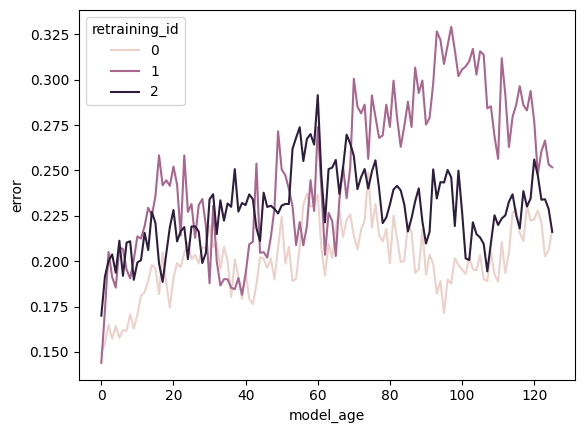

In [42]:
df = d_errors_df[d_errors_df['partition'] == 'prod']
df = df.groupby(['partition', 'retraining_id', 'model_age'])['error'].agg(lambda x: x.quantile([0.5])).rename('error').reset_index() 

sns.lineplot(data=df, x='model_age', y='error', hue='retraining_id')

In [12]:
d1 = d_errors_df[(d_errors_df['retraining_id'] == 0) & 
               (d_errors_df['partition'] == 'prod')].sort_values('model_age')
d2 = d_errors_df[(d_errors_df['retraining_id'] == 1) & 
               (d_errors_df['partition'] == 'prod')].sort_values('model_age')
d3 = d_errors_df[(d_errors_df['retraining_id'] == 2) & 
               (d_errors_df['partition'] == 'prod')].sort_values('model_age')

x1 = d1['model_age']
y1 = d1['error']

x2 = d2['model_age']
y2 = d2['error']

x3 = d3['model_age']
y3 = d3['error']

l1 = loess(x1, y1, span=0.05)
l1.fit()
pred1 = l1.predict(x1, stderror=True)
conf1 = pred1.confidence()

lowess1 = pred1.values
ll1 = conf1.lower
ul1 = conf1.upper

l2 = loess(x2, y2, span=0.05)
l2.fit()
pred2 = l2.predict(x2, stderror=True)
conf2 = pred2.confidence()

lowess2 = pred2.values
ll2 = conf2.lower
ul2 = conf2.upper

l3 = loess(x3, y3, span=0.05)
l3.fit()
pred3 = l3.predict(x3, stderror=True)
conf3 = pred3.confidence()

lowess3 = pred3.values
ll3 = conf3.lower
ul3 = conf3.upper

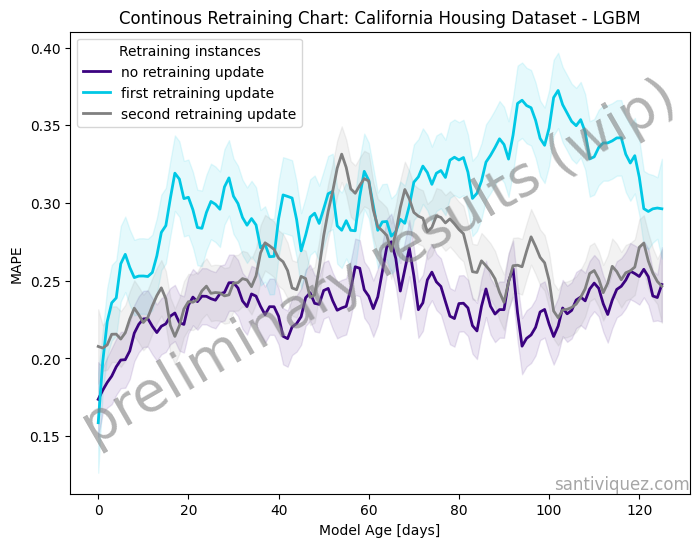

In [14]:
import numpy as np
import pylab as plt
from skmisc.loess import loess

fig, ax = plt.subplots(figsize=(8, 6))

plt.plot(x1, lowess1, label='no retraining update', color='#3b0280', linewidth=2.0)
plt.fill_between(x1, ll1, ul1, color='#3b0280', alpha=.10)

plt.plot(x2, lowess2, label='first retraining update', color='#00c8e5', linewidth=2.0)
plt.fill_between(x2, ll2, ul2, color='#00c8e5', alpha=.10)

plt.plot(x3, lowess3, label='second retraining update', color='grey', linewidth=2.0)
plt.fill_between(x3, ll3, ul3, color='grey', alpha=.10)
plt.legend(title='Retraining instances', loc="upper left")

ax.text(0.5, 0.5, 'preliminary results (wip)', transform=ax.transAxes,
        fontsize=40, color='gray', alpha=0.6,
        ha='center', va='center', rotation=30)
ax.text(1, 0.04, 'santiviquez.com', transform=ax.transAxes,
        fontsize=12, color='gray', alpha=0.7,
        ha='right', va='top')

plt.xlabel('Model Age [days]')
plt.ylabel('MAPE')
plt.title('Continous Retraining Chart: California Housing Dataset - LGBM')
#fig.tight_layout()

plt.savefig('../figures/retraining_chart_calhouse_lgbm_MAPE.png', format='png')

plt.show()